In [ ]:
import sys
sys.path.append('<path_of_GNEprop_repo>')
import clr
import data
import gneprop
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
import colorcet as cc
import seaborn as sns

sns.set_context('paper')
sns.set_style('white')

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load MoA Data

In [ ]:
stock = pd.read_csv('<path_of_your_enamine_dataset>')
stock.head()

,Unnamed: 0,Name,SMILES,Target
0,0,Actinomycin D,Cc1c2oc3c(C)ccc(C(=O)N[C@@H]4C(=O)N[C@H](C(C)C...,DNA/RNA synthesis
1,1,Alafosfalin,C[C@H](N)C(=O)N[C@@H](C)P(=O)(O)O,Alanine racimase
2,3,Amikacin,NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]...,Ribosome (30S)
3,6,Amoxicillin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,PBPs
4,7,Ampicillin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,PBPs


In [ ]:
# 1. Do some cleaning for the data

print('Original Shape: {}'.format(stock.shape))
target_label = 'Target'
stock = stock[~stock[target_label].isna()]
print('After Remove na: {}'.format(stock.shape))
stock = stock.drop_duplicates('Name')
print('After Remove duplicate Name: {}'.format(stock.shape))

In [4]:
stock['Target'].nunique()

30

In [5]:
# 2. Create Dataset

smiles_list = stock['SMILES'].values
stock_dataset = data.MolDatasetOD(smiles_list, include_smiles=True, legacy=True)
len(stock_dataset)

183

# 2. Generate Unsupervised Representations

In [ ]:
# 1. We load a pretrained unsupervised model

pretrain_dir = '<dir_of_unsupervised_checkpoint>'
pretrain_full_path = gneprop.utils.get_checkpoint_paths(checkpoint_dir=pretrain_dir)[0]

model_pretrained = clr.SimCLR.load_from_checkpoint(pretrain_full_path)
model_pretrained.eval()
# model_pretrained.to(device='cpu')

In [8]:
# 2. Generate representations using pretrained model

reprs_stock = model_pretrained.get_representations_dataset(stock_dataset, use_projection_layers=0, use_batch_norm=False)

100%|██████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s]


In [9]:
reprs_stock.shape

(183, 3000)

# 3. Generate UMAP Embedding from Model Embeddings

In [ ]:
SEED = 42
metric = 'euclidean'
n_neighbors = 75
min_dist = 0.1

reducer = umap.UMAP(random_state=SEED, metric=metric, n_neighbors=n_neighbors, min_dist=min_dist)
reducer.fit(reprs_stock)
umap_emb = reducer.transform(reprs_stock)

In [11]:
df_umap = pd.DataFrame(umap_emb, columns=['repr_x', 'repr_y'])
df_umap['Target'] = stock.reset_index(drop=True)['Target']

# 4. Create UMAP Plot

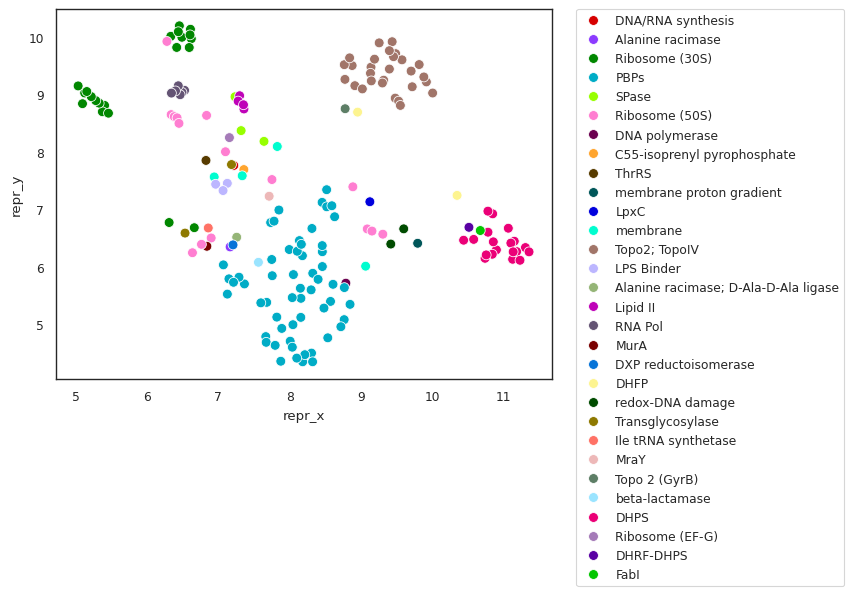

In [ ]:
palette = cc.glasbey[:30] 

sns.scatterplot(data=df_umap, x='repr_x', y='repr_y', hue='Target', palette=palette,  s=50)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()